In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import pickle

import tensorflow as tf

import os

In [2]:
print(tf.version.VERSION)

tf.config.run_functions_eagerly(True)

2.4.1


In [3]:
gpus = tf.config.list_physical_devices('GPU')

tf.config.experimental.set_visible_devices(gpus[1], 'GPU')

In [4]:
with open('../data/var1.pkl', 'rb') as file:
    train_data, test_data, e_params, t_params, ft_params = pickle.load(file)

In [5]:
# операция обратная стандартизации для восстановления результата
def restore_result(e_vals):
    return e_vals * e_params[1] + e_params[0]

# Dataset

## split_time_series

Разбивает временной ряд на части, перемещая "окно" размером $(input\_width + label\_width)$ с шагом step.

Образец составляют три вектора: 
1. Первый входной вектор $(input\_width \times input1\_columns)$ - информация о предыдущих элементах ряда (например, наблюдения за последнюю неделю, месяц) 
2. Второй входной вектор $(label\_width \times input2\_columns)$ - информация о прогнозируемых элементах ряда (например, дни недели и месяц прогнозируемых дней)
3. Выходной вектор $(label\_width \times label\_columns)$

Входной вектор разделен на две части, чтобы была возможность отдельно обрабатывать "исторические" данные (предыдущие наблюдения) и информацию о прогнозируемых элементах ряда.

Параметры:
- series - временной ряд
- input_width - размер входного вектора
- output_width - размер выходного вектора
- step - шаг перемещения окна
- input1_columns - список номеров колонок, значения которых должны присутствовать в первом входном векторе
- input2_columns - список номеров колонок, значения которых должны присутствовать во втором входном векторе
- label_columns - список номеров колонок, значения которых должны присутствовать в выходном векторе



In [15]:
def split_time_series(series, input_width, label_width,
                         step, input1_columns, input2_columns, label_columns):
    
    window_size = input_width + label_width
    
    res_len = (len(series) - window_size) // step + 1
    
    x1 = np.zeros((res_len, input_width, len(input1_columns)))
    x2 = np.zeros((res_len, label_width, len(input2_columns)))
    y = np.zeros((res_len, label_width, len(label_columns)))
    
    for i in range(res_len):
        x1[i] = series[i * step: i * step + input_width, input1_columns]
        x2[i] = series[i * step + input_width: i * step + window_size, input2_columns]
        y[i] = series[i * step + input_width : 
                      i * step + window_size, label_columns]
        
    x = [x1, x2] # np.concatenate([x1, x2])
        
    return x, y

## Параметры данной модели

Прогнозируются температура и энергопотребление одного дня, на вход подаются известные заранее параметры этого дня (день недели, выходной/праздник и т.д.), а также наблюдения за последнюю неделю. 

In [16]:
INPUT_WIDTH = 7
LABEL_WIDTH = 1
STEP = 1

INPUT1_COLUMNS = [0, 1]
INPUT2_COLUMNS = [2, 3, 8, 9, 10, 11, 12, 13]
LABEL_COLUMNS = [0, 1]

In [17]:
x_train, y_train = split_time_series(train_data.to_numpy(),
                                     INPUT_WIDTH, LABEL_WIDTH,
                                     STEP, INPUT1_COLUMNS, INPUT2_COLUMNS, LABEL_COLUMNS)
x_test, y_test = split_time_series(test_data.to_numpy(),
                                     INPUT_WIDTH, LABEL_WIDTH,
                                     STEP, INPUT1_COLUMNS, INPUT2_COLUMNS, LABEL_COLUMNS)

print(x_train[0].shape, x_train[1].shape, y_train.shape, '\n', 
      x_test[0].shape, x_test[1].shape, y_test.shape)

(1819, 7, 2) (1819, 1, 8) (1819, 1, 2) 
 (358, 7, 2) (358, 1, 8) (358, 1, 2)


# Model

In [18]:
# tf.keras.utils.set_random_seed(10)

BATCH_SIZE = 1
MAX_EPOCHS = 1000

In [26]:
'''
def build_model_2():    
    input1 = tf.keras.layers.Input(shape=(INPUT_WIDTH, len(INPUT1_COLUMNS)))
    flatten1 = tf.keras.layers.Flatten()(input1)
    dense11 = tf.keras.layers.Dense(8, activation='relu')(flatten1)
    dense12 = tf.keras.layers.Dense(8, activation='relu')(dense11)
    
    input2 = tf.keras.layers.Input(shape=(LABEL_WIDTH, len(INPUT2_COLUMNS)))
    flatten2 = tf.keras.layers.Flatten()(input2)
    dense21 = tf.keras.layers.Dense(16, activation='relu')(flatten2)
    dense22 = tf.keras.layers.Dense(8, activation='relu')(dense21)
    
    concat = tf.keras.layers.concatenate([dense12, dense22])
    dense3 = tf.keras.layers.Dense(16, activation='relu')(concat)
    output = tf.keras.layers.Dense(len(LABEL_COLUMNS))(dense3)
    
    reshape = tf.keras.layers.Reshape([LABEL_WIDTH, len(LABEL_COLUMNS)])(output)
    
    model = tf.keras.Model(inputs=[input1, input2], outputs=reshape)
    model.compile(optimizer='adam', loss='mse')
    
    return model

def build_model_1():    
    input1 = tf.keras.layers.Input(shape=(INPUT_WIDTH, len(INPUT1_COLUMNS)))
    flatten1 = tf.keras.layers.Flatten()(input1)
    
    input2 = tf.keras.layers.Input(shape=(LABEL_WIDTH, len(INPUT2_COLUMNS)))
    flatten2 = tf.keras.layers.Flatten()(input2)
    
    concat = tf.keras.layers.concatenate([flatten1, flatten2])
    
    dense1 = tf.keras.layers.Dense(64, activation='relu')(concat)
    dropout1 = tf.keras.layers.Dropout(0.5)(dense1)
    dense2 = tf.keras.layers.Dense(64, activation='relu')(dropout1)
    dropout2 = tf.keras.layers.Dropout(0.5)(dense2)
    
    output = tf.keras.layers.Dense(len(LABEL_COLUMNS))(dropout2)
    
    reshape = tf.keras.layers.Reshape([LABEL_WIDTH, len(LABEL_COLUMNS)])(output)
    
    model = tf.keras.Model(inputs=[input1, input2], outputs=reshape)
    model.compile(optimizer='adam', loss='mse')
    
    return model
'''

def build_model():    
    input1 = tf.keras.layers.Input(shape=(INPUT_WIDTH, len(INPUT1_COLUMNS)))
    flatten1 = tf.keras.layers.Flatten()(input1)
    
    input2 = tf.keras.layers.Input(shape=(LABEL_WIDTH, len(INPUT2_COLUMNS)))
    flatten2 = tf.keras.layers.Flatten()(input2)
    
    concat = tf.keras.layers.concatenate([flatten1, flatten2])
    
    dense1 = tf.keras.layers.Dense(8, activation='relu')(concat)
    dense2 = tf.keras.layers.Dense(8, activation='relu')(dense1)
    
    output = tf.keras.layers.Dense(len(LABEL_COLUMNS))(dense2)
    
    reshape = tf.keras.layers.Reshape([LABEL_WIDTH, len(LABEL_COLUMNS)])(output)
    
    model = tf.keras.Model(inputs=[input1, input2], outputs=reshape)
    model.compile(optimizer='adam', loss='mse')
    
    return model

In [27]:
model = build_model()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 7, 2)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1, 8)]       0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 14)           0           input_3[0][0]                    
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 8)            0           input_4[0][0]                    
____________________________________________________________________________________________

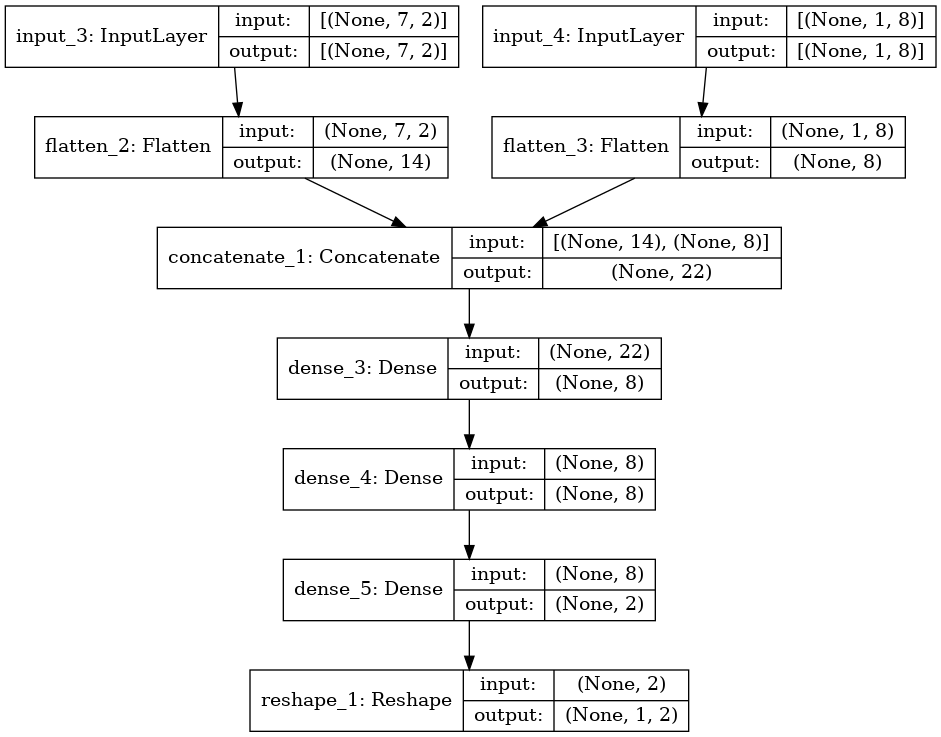

In [28]:
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)

In [29]:
print(x_train[0].shape, x_train[1].shape)

x = [np.expand_dims(x_train[0][0], 0), 
     np.expand_dims(x_train[1][0], 0)]

print(model(x))

(1819, 7, 2) (1819, 1, 8)
tf.Tensor([[[-0.54613113  0.8254827 ]]], shape=(1, 1, 2), dtype=float32)


### Конфигурация tensorboard для наблюдения за процессом обучения

In [30]:
model_path = "../models/mlp_01/01/"
log_dir = model_path + "logs/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                         update_freq='batch')

### Конфигурация сохранения весов модели в процессе обучения

In [31]:
checkpoint_name = model_path + "checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_name)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
                    filepath = checkpoint_name, 
                    verbose = 1, 
                    save_weights_only = True,
                    save_freq = 10 * len(x_train[0]))

### Загрузка последнего (или наиболее успешного) чекпоинта 

In [32]:
# latest = tf.train.latest_checkpoint(checkpoint_dir)
# model.load_weights(latest)

model.load_weights(model_path + "checkpoints/cp-0070.ckpt")

### Обучение модели

In [ ]:
model.fit(x_train, y_train, 
          validation_data = (x_test, y_test),
          batch_size = BATCH_SIZE, 
          epochs = MAX_EPOCHS, 
          callbacks = [tensorboard_callback, cp_callback])

# Визуализация прогноизрования

In [33]:
from matplotlib import pyplot as plt

## На обучающей выборке

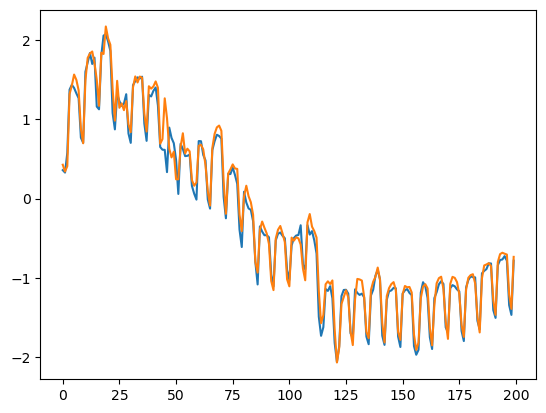

In [34]:
plt.plot(np.squeeze(y_train)[:200,0])
plt.plot(np.squeeze(model(x_train))[:200,0])

plt.show()

## На валидационной выборке

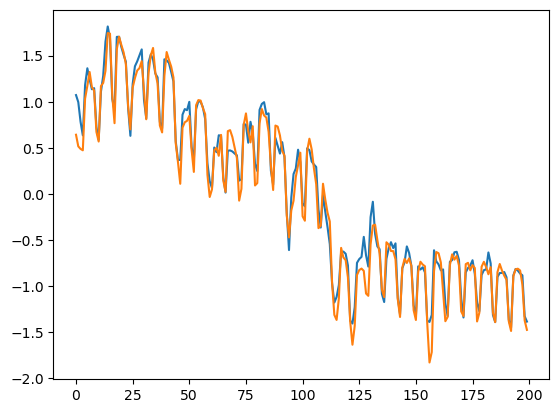

In [35]:
plt.plot(np.squeeze(y_test)[:200,0])
plt.plot(np.squeeze(model(x_test))[:200,0])

plt.show()

# Функция построения прогноза

In [38]:
def predict():
    total_series = np.concatenate([train_data, test_data])
    total_series = total_series[len(train_data) - INPUT_WIDTH :]
    
    predicted = np.zeros((len(test_data)))
    
    for i in range(len(predicted)):
        x1 = np.expand_dims(total_series[i : i + INPUT_WIDTH, INPUT1_COLUMNS], 0)
        x2 = np.expand_dims(total_series[i + INPUT_WIDTH : 
                                         i + INPUT_WIDTH + LABEL_WIDTH, 
                                         INPUT2_COLUMNS], 0)
        y = model([x1, x2])
        
        predicted[i] = y[0, 0, 0]
        total_series[i + INPUT_WIDTH, 1] = y[0, 0, 1]
        
    predicted = restore_result(predicted)
        
    return predicted

# Оценка модели

In [39]:
predicted = predict()

ground_truth = restore_result(test_data.to_numpy()[:,0])

            |    RMSE    |  MAPE (%)  | PBias (%)  |     R2     
------------|------------|------------|------------|------------
    MLP     |  277.505   |   1.775    |   -0.368   |   0.968    



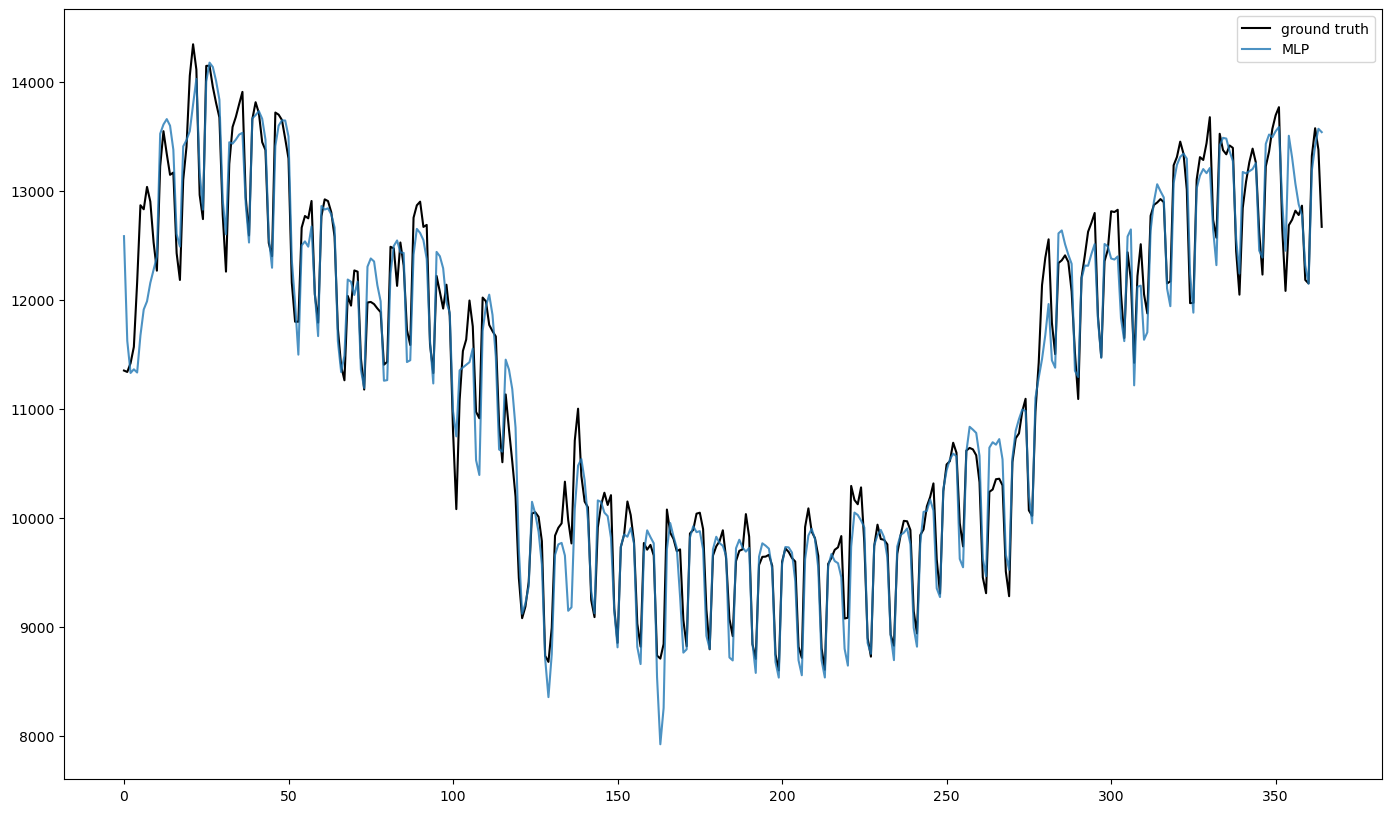

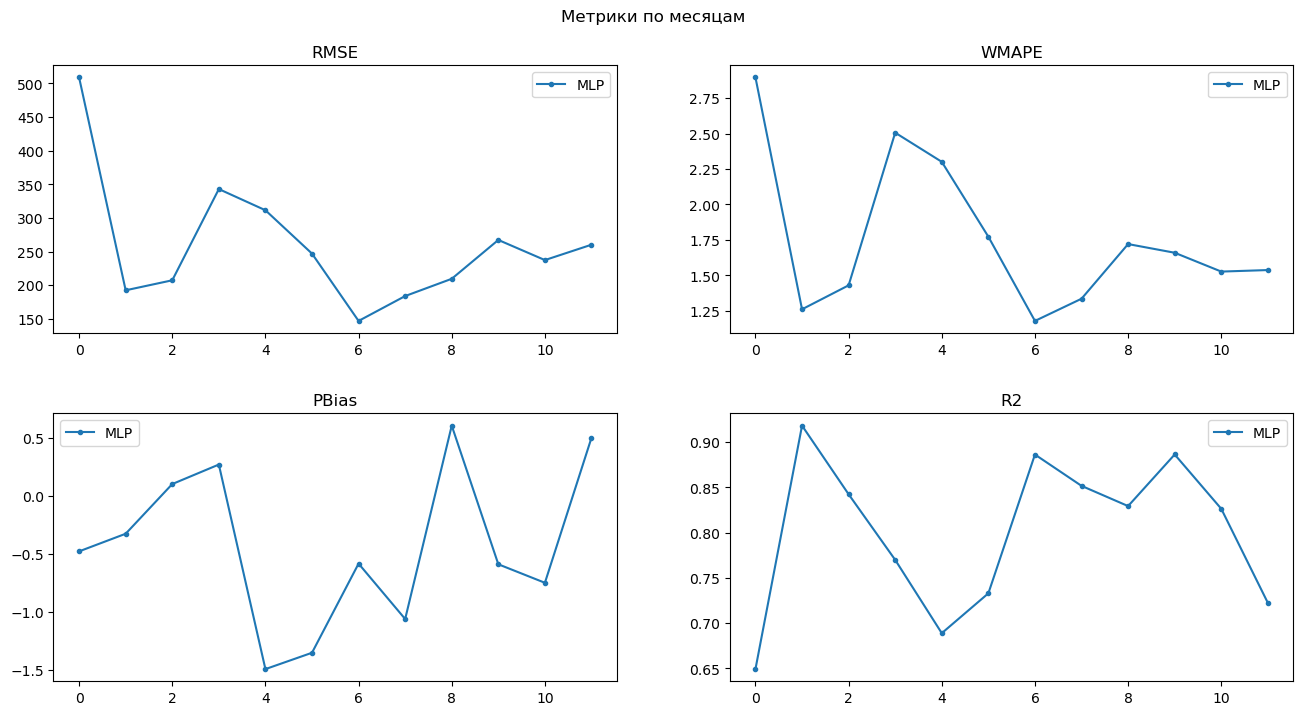

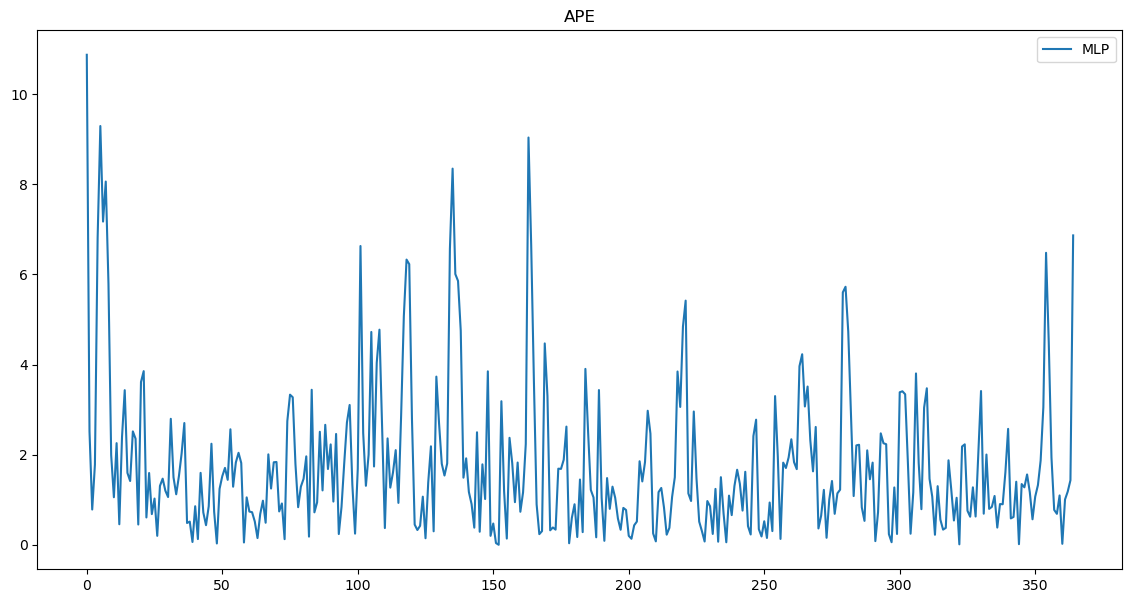

In [42]:
%run evaluate_forecasts.ipynb

evaluate_forecasts(ground_truth, [predicted], ['MLP'])